# Cancer Binary Classification

The goal of this project is to predict whether a tumor is malignant or benign. This is a binary classification task, and the algorithm I chose for this is logistic regression since the parameters are all numerical and the data should have a linear relationship. By leveraging this algorithm I want to obtain accurate predictions that focus especially on minimizing false negatives (maximizing recall statistic) while still maintaining high accuracy because a misdiagnosis of a tumor as benign while malignant can result in a patient losing their life, while if a benign tumor is classified as malignant the patient would most likely just get additional tests.

The dataset used for this project comes from Kaggle. It consists of cancer diagnosis parameters such as radius, texture, symmetry, and concavity. Citation: Taha, Erdem (2023). Cancer Data Version 1. Retrieved April 2, 2024 from https://www.kaggle.com/datasets/erdemtaha/cancer-data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import preprocessing, metrics
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
df = pd.read_csv('https://drive.usercontent.google.com/uc?id=1T5g7QmderB6zr3ubZeyLEJnKyLkVeA74&export=download')

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
df.drop(columns = ['id', 'Unnamed: 32'], inplace=True)

First we drop the two columns we will not be using since they are not correlated with the diagnosis outcome. We then check the Dtypes to make sure there is nothing weird going on with those and making sure we have the same amount of rows for each column. We then describe the data statistics, which helps us gather information about the distribution of the data as well as any possible egregious min and max values that may be outliers. We then check that there are no null values, as well as making sure 0 values are not classified as null (since tumors might for example have 0 concavity). We then make sure the dataset is balanced to identify whether we need to use any oversampling or undersampling techniques.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [6]:
df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [7]:
nul_vals = df.isnull()
nul_vals.sum()

diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [8]:
print(df['diagnosis'].value_counts())

diagnosis
B    357
M    212
Name: count, dtype: int64


Now that we know the data is cleaned and mostly balanced we can move on to correlation analysis. The goal here is to remove parameters that are highly correlated because we do not want multiple predictors measuring the same thing and skewing the results.

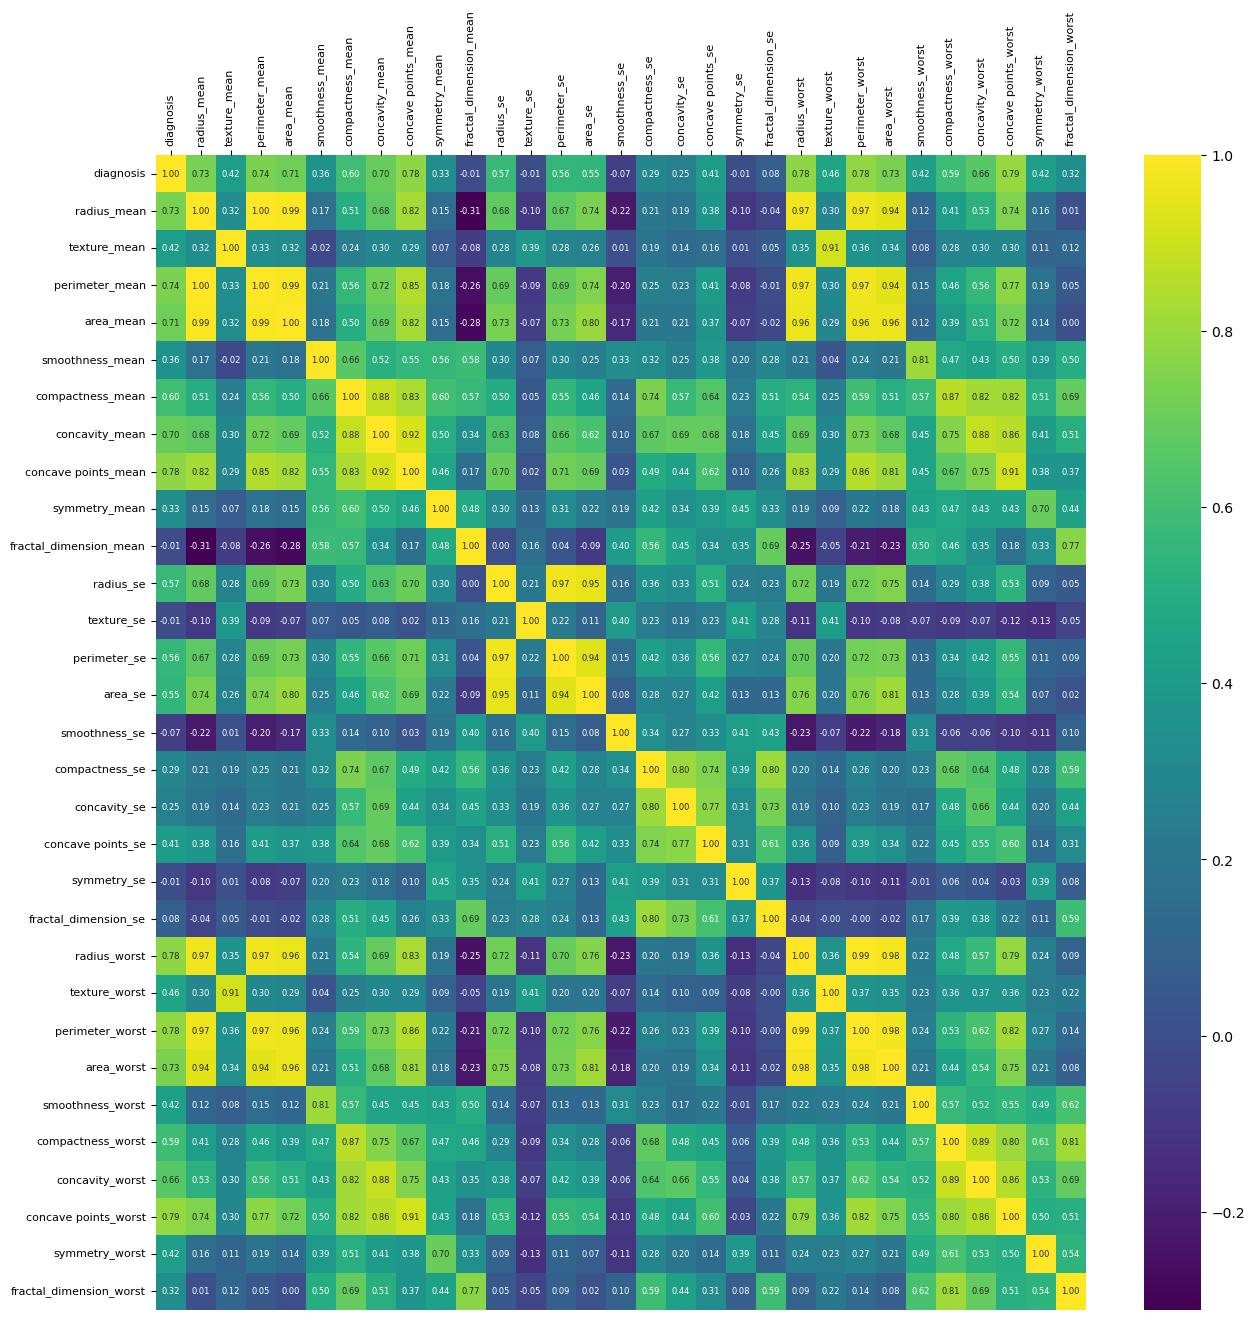

In [9]:
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})
corr = df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', annot_kws={"size": 6})
plt.gca().xaxis.tick_top()
plt.xticks(fontsize=8, rotation=90)
plt.yticks(fontsize=8)
plt.show()

We can see that we have a lot of correlated parameters in this dataset. There are even groups of correlated parameters not just pairs, so we need to find groups where all of the parameters are correlated together and we need to only use the best predictor out of those parameters.

In [10]:
correlated_pairs = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > 0.9:
            correlated_pairs.append((corr.columns[i], corr.columns[j]))

correlated_groups = []
for predictor_pair in correlated_pairs:
    for group in correlated_groups:
        if predictor_pair[0] in group or predictor_pair[1] in group:
            group.add(predictor_pair[0])
            group.add(predictor_pair[1])
            break
    else:
        correlated_groups.append(set(predictor_pair))

for i, group in enumerate(correlated_groups):
    print(f"Group {i+1}: {', '.join(group)}")

Group 1: area_mean, perimeter_worst, radius_mean, radius_worst, perimeter_mean, area_worst
Group 2: texture_worst, texture_mean
Group 3: concavity_mean, concave points_mean, concave points_worst
Group 4: radius_se, perimeter_se, area_se


Now let's figure out what are the best predictors.

In [11]:
np.fill_diagonal(corr.values, np.nan)
best_predictors = corr['diagnosis'].abs().sort_values(ascending=False)
print(best_predictors)

concave points_worst       0.793566
perimeter_worst            0.782914
concave points_mean        0.776614
radius_worst               0.776454
perimeter_mean             0.742636
area_worst                 0.733825
radius_mean                0.730029
area_mean                  0.708984
concavity_mean             0.696360
concavity_worst            0.659610
compactness_mean           0.596534
compactness_worst          0.590998
radius_se                  0.567134
perimeter_se               0.556141
area_se                    0.548236
texture_worst              0.456903
smoothness_worst           0.421465
symmetry_worst             0.416294
texture_mean               0.415185
concave points_se          0.408042
smoothness_mean            0.358560
symmetry_mean              0.330499
fractal_dimension_worst    0.323872
compactness_se             0.292999
concavity_se               0.253730
fractal_dimension_se       0.077972
smoothness_se              0.067016
fractal_dimension_mean     0

Now that we know the best predictors in the dataset, let's find out which predictor in our correlated groups is the best predictor.

In [12]:
best_predictors_in_group = {}
for group in correlated_groups:
    max_value = 0
    best_predictor = None
    for predictor in group:
        if best_predictors[predictor] > max_value:
            max_value = best_predictors[predictor]
            best_predictor = predictor
    best_predictors_in_group[tuple(group)] = best_predictor

for i, (group, best_predictor) in enumerate(best_predictors_in_group.items()):
    print(f"Group {i+1} best predictor: {best_predictor}")

Group 1 best predictor: perimeter_worst
Group 2 best predictor: texture_worst
Group 3 best predictor: concave points_worst
Group 4 best predictor: radius_se


So now we know the best predictor for each correlated group and we can drop the rest of the predictors for each group. I also decided to drop some other predictors that had very low correlation values with the diagnosis compared to other predictors.

In [13]:
predictors_to_drop = []
for group, best_predictor in best_predictors_in_group.items():
    for predictor in group:
        if predictor != best_predictor:
            predictors_to_drop.append(predictor)
print(predictors_to_drop)

['area_mean', 'radius_mean', 'radius_worst', 'perimeter_mean', 'area_worst', 'texture_mean', 'concavity_mean', 'concave points_mean', 'perimeter_se', 'area_se']


In [14]:
df.drop(columns=predictors_to_drop, inplace=True)
df.drop(columns=['fractal_dimension_se', 'smoothness_se', 'fractal_dimension_mean', 'texture_se', 'symmetry_se'], inplace=True)
df.head()

,diagnosis,smoothness_mean,compactness_mean,symmetry_mean,radius_se,compactness_se,concavity_se,concave points_se,texture_worst,perimeter_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,0.11840,0.27760,0.2419,1.0950,0.04904,0.05373,0.01587,17.33,184.60,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,0.08474,0.07864,0.1812,0.5435,0.01308,0.01860,0.01340,23.41,158.80,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,0.10960,0.15990,0.2069,0.7456,0.04006,0.03832,0.02058,25.53,152.50,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,0.14250,0.28390,0.2597,0.4956,0.07458,0.05661,0.01867,26.50,98.87,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,0.10030,0.13280,0.1809,0.7572,0.02461,0.05688,0.01885,16.67,152.20,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Our data is looking mighty fine now with correlated values dropped and best predictors found! Let's scale our features and apply the model.

In [15]:
scaler = preprocessing.StandardScaler()
X = df.drop(columns = 'diagnosis').values
X = scaler.fit_transform(X)
y = df['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=5)

In [32]:
LogReg = LogisticRegression(random_state=5)
LogReg.fit(x_train, y_train)
y_prob = LogReg.predict_proba(x_test)[:, 1]

In [18]:
y_pred = LogReg.predict(x_test)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

F1 Score: 0.971
Precision: 0.986
Recall: 0.958


So we can see that we achieved high metrics scores, but we do want to maximize the recall statistic as we mentioned at the very beginning. Let's see if we can do better by adjusting the threshold.

In [19]:
thresholds = np.arange(0.1, 1.0, 0.1)
best_recall = 0
best_threshold = 0
for threshold in thresholds:
    y_pred = (y_prob >= threshold)
    recall = recall_score(y_test, y_pred)
    if recall > best_recall:
        best_recall = recall
        best_threshold = threshold
y_pred = (y_prob >= best_threshold)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Best Threshold: {best_threshold:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {best_recall:.3f}")

Best Threshold: 0.100
F1 Score: 0.903
Precision: 0.833
Recall: 0.986


Now we achieved slightly higher recall but we did sacrifice a lot of precision, lets maybe optimize this where F1 Score is greater than 0.96.

In [35]:
thresholds = np.arange(0.1, 1.0, 0.1)
best_recall = 0
best_threshold = 0
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_prob >= threshold)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    if f1 > 0.96 and recall > best_recall:
        best_recall = recall
        best_threshold = threshold
        best_f1 = f1

precision = precision_score(y_test, (y_prob >= best_threshold))

print(f"Best Threshold: {best_threshold:.3f}")
print(f"F1 Score: {best_f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {best_recall:.3f}")

Best Threshold: 0.400
F1 Score: 0.965
Precision: 0.971
Recall: 0.958


Looks like we can't get the recall much higher than 0.958 without sacrificing precision by changing the threhold values so sticking with the default threshold value seems optimal. Still, we achieved excellent results with an F1 score of 0.971, precision score of 0.986 and recall score of 0.958. Let's go back to the original model and create some final metrics and appropriate visualizations.

In [42]:
y_pred = LogReg.predict(x_test)
print(f"Classification report :\n {metrics.classification_report(y_test,y_pred)} \n")

Classification report :
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       129
           1       0.99      0.96      0.97        71

    accuracy                           0.98       200
   macro avg       0.98      0.97      0.98       200
weighted avg       0.98      0.98      0.98       200
 



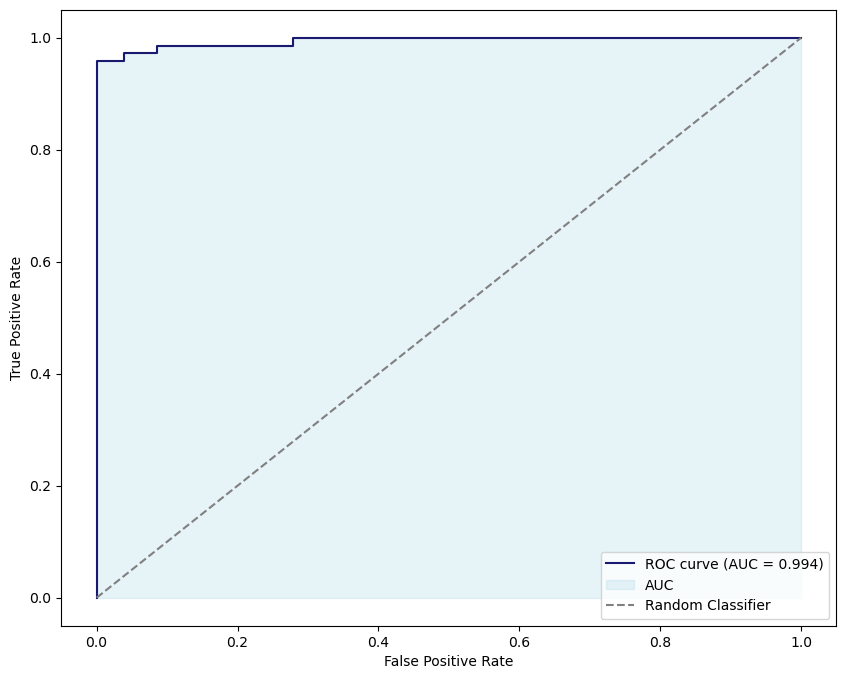

In [34]:
fpr, tpr, threshholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr, color='midnightblue', label='ROC curve (AUC = {:.3f})'.format(roc_auc))
plt.fill_between(fpr, tpr, color='lightblue', alpha=0.3, label='AUC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

To summarize, the objective of this project was to create a logistic regression model predicting whether a tumor was benign or malignant based on parameters such as symmetry, concavity, radius, etc. I conducted thorough exploratory data analysis by first inspecting the data for any outliers and null values, assessing the distribution of the data, and checking for balance between classes. I then conducted correlation analysis and found the best predictors to streamline the dataset and retain only the most important predictors. I used standard scaling to balance the predictors and applied the logistic regression model. I attempted to adjust the threshold hyperparameter to achieve better recall but the best results were achieved with the default threshold. We achieved excellent results with an F1 score of 0.971, precision score of 0.986 and recall score of 0.958. The ROC curve further confirms our model's predictive capabilities. Some limitations worth mentioning in this project are that we only used one model. By using multiple models we would likely achieve even better results.